In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import model
import datasets

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms, utils
from copy import *

In [2]:
# Make sure to use the GPU. The following line is just a check to see if GPU is availables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
"""
The code below creates the datasets out of the different inputted text files
and prepares it in a dataloader to get processed by the cnn models.
"""
data_transform=transforms.Compose([transforms.RandomResizedCrop(224),  transforms.RandomHorizontalFlip(), transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
root = 'birds_dataset/'
test_dataset = datasets.bird_dataset(root,'test_list.txt')

train_dataset_1 = datasets.bird_dataset(root,'train_set1.txt')
val_dataset_1 = datasets.bird_dataset(root,'val_set1.txt')

train_dataset_2 = datasets.bird_dataset(root,'train_set2.txt')
val_dataset_2 = datasets.bird_dataset(root,'val_set2.txt')

# Fill in optional arguments to the dataloader as you need it

#holdout set 1
train_dataset_1_dataloader = DataLoader(train_dataset_1, batch_size=4,
                                          shuffle=True, num_workers=2)
val_dataset_1_dataloader = DataLoader(val_dataset_1, batch_size=4,
                                         shuffle=False, num_workers=2)

#holdout set 2
train_dataset_2_dataloader = DataLoader(train_dataset_2, batch_size=4,
                                          shuffle=True, num_workers=2)
val_dataset_2_dataloader = DataLoader(val_dataset_2, batch_size=4,
                                         shuffle=False, num_workers=2)

#test set
test_dataloader = DataLoader(test_dataset, batch_size=1,
                                         shuffle=False, num_workers=2)




In [7]:
train_dataset_1_dataloader.dataset[0][0].shape

AttributeError: 'Image' object has no attribute 'shape'

In [4]:
"""
This is the cross_validation method which we use to evaluate the performance of the
holdout sets which includes a training set and a validation set. We save the accuracies, loss,
and create a deep copy of the model for later.
"""
def cross_validation(num_epochs, train_dataloader, val_dataloader):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        counter = 0
        correct = 0
        total = 0
        
        for data in train_dataloader:
            counter+=1
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = nn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # collect accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # collect loss
            running_loss += loss.item()
        train_loss.append(running_loss/counter)
        train_acc.append(correct / total)

        running_loss = 0.0
        counter = 0
        correct = 0
        total = 0
        with torch.no_grad():
            nn_model.eval()
            for data in val_dataloader:
                counter += 1
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = nn_model(images)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                running_loss += loss.item()
        val_loss.append(running_loss/counter)
        val_acc.append(correct / total)
        
        output_acc = np.mean(val_acc[-5:])
    
    return np.array(train_loss), np.array(val_loss), np.array(train_acc), np.array(val_acc), (deepcopy(nn_model), output_acc)


In [5]:
"""
Create NN model object for holdout set 1
"""
nn_model = model.resnet_Net(classes = 20)
nn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-4)

In [6]:
"""
Cross-validation for holdout set 1
"""
train_loss1, val_loss1, train_acc1, val_acc1, result1 = cross_validation(50, train_dataset_1_dataloader, val_dataset_1_dataloader)

In [7]:
"""
Create NN model object for holdout set 2
"""
nn_model = model.resnet_Net(classes = 20)
nn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-4)

In [8]:
"""
Cross-validation for holdout set 2
"""
train_loss2, val_loss2, train_acc2, val_acc2, result2 = cross_validation(50, train_dataset_2_dataloader, val_dataset_2_dataloader)

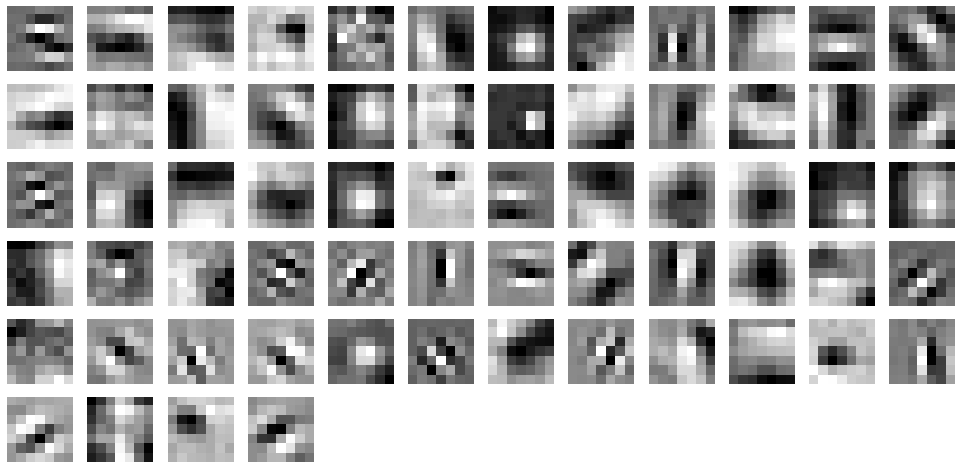

In [9]:
"""
Displays the weights map for the cnn model.
"""
model_weights = []

for m in nn_model.modules():
    if isinstance(m, nn.Conv2d):
        model_weights.append(m.weight.data)

# visualize the first conv layer filters
plt.figure(figsize=(17, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(12, 12, i+1) 
    
    plt.imshow(filter[0, :, :].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [10]:
# print(list(list(list(list(nn_model.children())[0].children())[4].children())[0].children())[0])


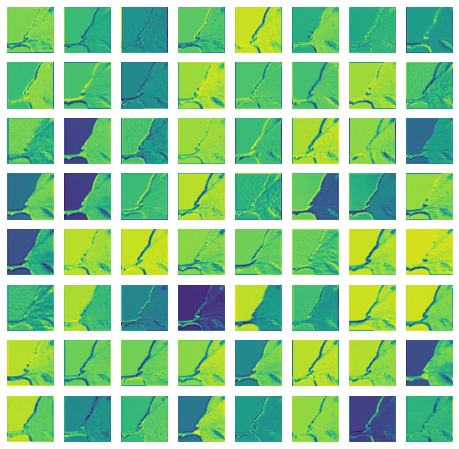

In [11]:
"""
Features map for the Resnet model
"""
img = datasets.bird_dataset(root,'feature_vis.txt')[0][0].cuda()

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# layer_cov = list(list(nn_model.children())[0].children())[0]
layer_cov = list(list(list(list(nn_model.children())[0].children())[4].children())[0].children())[0]

layer_cov.register_forward_hook(get_activation(layer_cov))
img.unsqueeze_(0)
output = nn_model(img)

activation = activation[layer_cov].squeeze()

plt.figure(figsize=(8, 8))

for index in range(len(activation)):
    img = activation[index,:,:]
    
    if index <= 63 and index >= 0:
        plt.subplot(8, 8, index+1)
        plt.imshow(img.cpu().detach().numpy())
        plt.axis('off')
        plt.savefig('birds_feature.png')

In [12]:
# """
# Features map for the Vgg16 model
# """
# img = datasets.bird_dataset(root,'feature_vis.txt')[0][0].cuda()

# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# layer_cov = list(nn_model.children())[0][7]

# layer_cov.register_forward_hook(get_activation(layer_cov))
# img.unsqueeze_(0)
# output = nn_model(img)

# activation = activation[layer_cov].squeeze()

# plt.figure(figsize=(8, 8))

# for index in range(len(activation)):
#     img = activation[index,:,:]
    
#     if index <= 63 and index >= 0:
#         plt.subplot(8, 8, index+1)
#         plt.imshow(img.cpu().detach().numpy())
#         plt.axis('off')
#         plt.savefig('birds_feature.png')

In [13]:
"""
Features map for the Custom/Baseline models
"""
# img = datasets.bird_dataset(root,'feature_vis.txt')[0][0].cuda()

# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook
# nn_model.b3.register_forward_hook(get_activation('b3'))
# img.unsqueeze_(0)
# output = nn_model(img)

# activation = activation['b3'].squeeze()

# plt.figure(figsize=(8, 8))

# for index in range(len(activation)):
#     img = activation[index,:,:]
    
#     if index <= 63 and index >= 0:
#         plt.subplot(8, 8, index+1)
#         plt.imshow(img.cpu().detach().numpy())
#         plt.axis('off')
#         plt.savefig('birds_feature.png')



'\nFeatures map for the Custom/Baseline models\n'

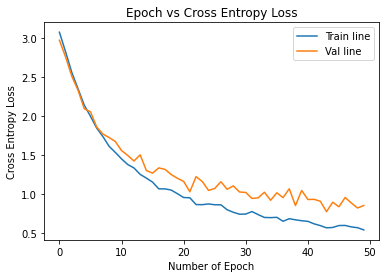

In [14]:
"""
Plots the avg. loss curves for holdout set 1 and holdout set 2
"""
train_loss = (train_loss1 + train_loss2) / 2
val_loss = (val_loss1 + val_loss2) / 2

plt.errorbar(range(len(train_loss)), train_loss, label='Train line')
plt.errorbar(range(len(val_loss)), val_loss, label='Val line')
plt.title('Epoch vs Cross Entropy Loss')
plt.xlabel('Number of Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

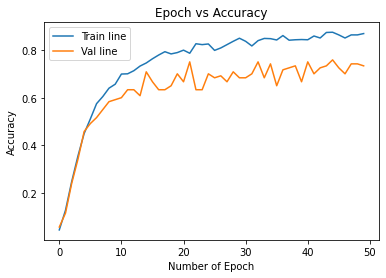

In [15]:
"""
Plots the avg. accuracy curves for holdout set 1 and holdout set 2
"""
train_acc = (train_acc1 + train_acc2)/2
val_acc = (val_acc1 + val_acc2)/2

plt.errorbar(range(len(train_acc)), train_acc, label='Train line')
plt.errorbar(range(len(val_acc)), val_acc, label='Val line')
plt.title('Epoch vs Accuracy')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
"""
Saves the best model after comparing holdout set 1 and holdout set 2
"""
val_set1_acc = result1[1]
val_set2_acc = result2[1]
print("train_set acc: " + str(train_acc[-2]))
print("val_set1 acc: " + str(val_set1_acc))
print("val_set2 acc: " + str(val_set2_acc))
if val_set1_acc > val_set2_acc:
    best_model = result1[0]
else:
    best_model = result2[0]



train_set acc: 0.8629629629629629
val_set1 acc: 0.7133333333333333
val_set2 acc: 0.7433333333333334


In [17]:
"""
Displays the accuracy of the test set using the best model found above
"""
total = 0
correct = 0
with torch.no_grad():
    best_model.eval()
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 76 %
